In [1]:
import numpy as np
from scipy.ndimage import generic_filter
from skimage.metrics import structural_similarity as ssim
import cv2
import matplotlib.pyplot as plt

def patch_inpaint(images, masks, patch_size=3):
    N, H, W = images.shape
    pad = patch_size // 2
    inpainted = images.copy()

    for idx in range(N):
        img = inpainted[idx]
        mask = masks[idx]

        # Pad image and mask for border handling
        padded_img = np.pad(img, pad, mode='reflect')
        padded_mask = np.pad(mask, pad, mode='constant', constant_values=1)

        # Function to inpaint a single pixel using neighbors
        def inpaint_func(patch):
            center_mask = patch[len(patch)//2]
            if center_mask == 1:
                # If the center pixel is masked, use mean of unmasked neighbors
                neighbor_values = patch[:len(patch)//2] + patch[len(patch)//2+1:]
                valid_neighbors = [v for v, m in zip(neighbor_values, patch_masks) if m == 0]
                return np.mean(valid_neighbors) if valid_neighbors else 0
            else:
                return patch[len(patch)//2]  # original pixel value

        # Apply filter only on masked pixels
        for i in range(H):
            for j in range(W):
                if mask[i, j] == 1:
                    # Extract patch and corresponding mask
                    patch = padded_img[i:i+patch_size, j:j+patch_size]
                    patch_mask = padded_mask[i:i+patch_size, j:j+patch_size].flatten()
                    patch_values = patch.flatten()
                    patch_masks = patch_mask

                    # Use only unmasked neighbors for inpainting
                    center_index = (patch_size * patch_size) // 2
                    neighbors = [v for k, v in enumerate(patch_values) if k != center_index and patch_masks[k] == 0]

                    if neighbors:
                        img[i, j] = np.mean(neighbors)
                    else:
                        img[i, j] = 0  # fallback if no valid neighbors

        inpainted[idx] = img

    return inpainted

#using cv2 
def inpaint_with_cv2(images, masks, method=cv2.INPAINT_TELEA):
    N, H, W = images.shape
    inpainted = np.empty_like(images)
    for i in range(N):
        img = images[i].astype(np.uint8)
        mask = (masks[i] > 0).astype(np.uint8) * 255
        inpainted[i] = cv2.inpaint(img, mask, inpaintRadius=3, flags=method)
    return inpainted

#now for converting from the yolo_boxes to the box masks 
def yolo_boxes_to_masks(yolo_boxes, image_size=28):
    """
    Convert N x 4 YOLO boxes (cx, cy, w, h) to N x 28 x 28 binary masks.

    Parameters:
        yolo_boxes: np.ndarray of shape (N, 4), values in [0, 1]
        image_size: int, size of the output mask (default 28)

    Returns:
        masks: np.ndarray of shape (N, 28, 28), dtype=np.uint8
    """
    N = yolo_boxes.shape[0]
    masks = np.zeros((N, image_size, image_size), dtype=np.uint8)

    for i in range(N):
        cx, cy, w, h = yolo_boxes[i]
        
        # Convert normalized coordinates to pixel values
        px = int(cx * image_size)
        py = int(cy * image_size)
        pw = int(w * image_size)
        ph = int(h * image_size)
        
        # Calculate top-left and bottom-right corners
        x1 = max(0, px - pw // 2)
        y1 = max(0, py - ph // 2)
        x2 = min(image_size, px + (pw + 1) // 2)
        y2 = min(image_size, py + (ph + 1) // 2)

        # Set the mask region to 1
        masks[i, y1:y2, x1:x2] = 1

    return masks

In [4]:
#get the masks and the corrupted images, then run it through and see what happens 
true_boxes = np.load("yolo_boxes/boxes_true.npy")
print(true_boxes.shape)

#make the mask from these boxes 
true_masks = yolo_boxes_to_masks(true_boxes)
print(true_masks.shape)

#get the corrupted images 
corrupted_images = np.empty((0, 28, 28))
for i in range(0, 56000, 4615): 
    #take from i to i+4614 for the training set and set its label to 1 (for corrupted = true) 
    file_num = int((i/4615)*5 + 10) # get the number of the thing we should be on 
    current_np = np.load("mnist_obfuscated/mnist_" + str(file_num) + ".npy")
    corrupted_images = np.concatenate((corrupted_images, current_np[i:i+4615]), axis = 0)

#get the true images - should also start at 0 
true_images = np.load("mnist_files/mnist_img.npy")[:59995]


print(true_images.shape)
print(corrupted_images.shape)

(59995, 4)
(59995, 28, 28)
(59995, 28, 28)
(59995, 28, 28)


In [8]:
np.save("mnist_files/mnist_true_test", true_images)
np.save("mnist_files/mnist_corrupted_test", corrupted_images)

In [43]:
#for pulling up information again without overwriting the current inpainted_images var 
inpainted_image2 = np.load("mnist_files/Telea_inpainted_test.npy")
ssim_scores2 = [ssim(inpainted_image2[i], true_images[i], data_range = 255.0) for i in range(inpainted_images.shape[0])]
print(np.mean(ssim_scores2))

0.5454853757530561


In [39]:
inpainted_images = patch_inpaint(corrupted_images, true_fitted_mask)



In [40]:
np.save("mnist_files/patch_inpainted_test", inpainted_images)


In [41]:
print(inpainted_images.shape[0])
ssim_scores = [ssim(inpainted_images[i], true_images[i], data_range = 255.0) for i in range(inpainted_images.shape[0])]
print(np.mean(ssim_scores))

59995
0.5587106849919303


In [15]:
print(np.mean(ssim_scores[:4615]))

0.9003264681920201


In [16]:
pre_inpainted_ssim_scores = [ssim(corrupted_images[i], true_images[i], data_range = 255.0) for i in range(inpainted_images.shape[0])]


0.5199570844814652
0.8766186129747422


In [50]:
print(np.mean(pre_inpainted_ssim_scores))
split_by_level = []
for i in range(0, 56000, 4615):
    split_by_level.append(np.mean(ssim_scores[i:i+4615]))
print(split_by_level)

0.5199570844814652
[0.9076302324770678, 0.8521227660745895, 0.7883481937475323, 0.7179064428050609, 0.6365740459280101, 0.6062196058840107, 0.5292826934865673, 0.4526471936797888, 0.4308484224992568, 0.3753281869298855, 0.3485430390632595, 0.32161519714013753, 0.2961728851799279]


In [6]:
np.save("mnist_files/true_masks_test", true_masks)


In [9]:
true_fitted_mask = np.empty((0, 28, 28)) 
for i in range(0, 56000, 4615): 
    file_num = int((i/4615)*5 + 10) # get the number of the thing we should be on 
    current_np = np.load("mask/mask_" + str(file_num) + ".npy")
    true_fitted_mask = np.concatenate((true_fitted_mask, current_np[i:i+4615]), axis = 0)
print(true_fitted_mask.shape)
np.save("mnist_files/true_fitted_mask_test", true_fitted_mask)


(59995, 28, 28)


In [7]:
import numpy as np

def mae_grayscale(I: np.ndarray, K: np.ndarray) -> float:
    """
    Compute Mean Absolute Error between two grayscale images.
    
    Args:
      I: Ground-truth image, shape (H, W).
      K: Predicted image, shape (H, W).
    
    Returns:
      MAE value (float).
    """
    # Ensure float computation
    I = I.astype(np.float32)
    K = K.astype(np.float32)
    # Compute absolute differences
    abs_diff = np.abs(I - K)
    # Return mean over all pixels
    return abs_diff.mean() /255  # for [0-1 value]

In [46]:
mae_scores = [mae_grayscale(inpainted_images[i], true_images[i]) for i in range(inpainted_images.shape[0])]

In [47]:
print(sum(mae_scores)/len(mae_scores))

0.07611158761773404


In [48]:
#make the graph for splitting by occlusion size 
mae_split_scores = []
keys = [5*i + 10 for i in range(0, 13)]
for i in range(0, 56000, 4615):
    mae_split_scores.append(1 - np.mean(mae_scores[i:i+4615]))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


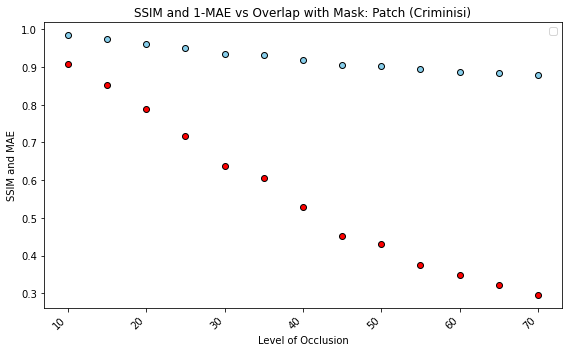

In [52]:
plt.figure(figsize=(8, 5))
plt.scatter(keys, mae_split_scores, color='skyblue', edgecolor='black')
plt.scatter(keys, split_by_level, color='red', edgecolor='black')
plt.title("SSIM and 1-MAE vs Overlap with Mask: Patch (Criminisi)")
plt.xlabel("Level of Occlusion")
plt.ylabel("SSIM and MAE")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig("mnist_obfuscated/Patch_inpainted.png", dpi=300)
plt.show()

ModuleNotFoundError: No module named 'lama_cleaner'

In [55]:
#make smaller test set for lama 
smaller_test_mask = np.empty((0, 28, 28)) 
smaller_test_image_corrupted = np.empty((0, 28, 28)) 
smaller_test_image_true = np.empty((0, 28, 28)) 
for i in range(0, 56000, 4615): 
    smaller_test_mask = np.concatenate((smaller_test_mask, true_fitted_mask[i:i+200]), axis = 0)
    smaller_test_image_corrupted = np.concatenate((smaller_test_image_corrupted, corrupted_images[i:i+200]), axis = 0)
    smaller_test_image_true = np.concatenate((smaller_test_image_true, true_images[i:i+200]), axis = 0)

print(smaller_test_mask.shape)
print(smaller_test_image_true.shape)
print(smaller_test_image_corrupted.shape)

(2600, 28, 28)
(2600, 28, 28)
(2600, 28, 28)


In [56]:
np.save("mnist_files/small_test_mask", smaller_test_mask)
np.save("mnist_files/small_test_corrupt", smaller_test_image_corrupted)
np.save("mnist_files/small_test_true", smaller_test_image_true)

In [4]:
#load the lama inpainted to check its performance
smaller_test_mask = np.load("mnist_files/small_test_mask.npy")
smaller_test_image_corrupted = np.load("mnist_files/small_test_corrupt.npy")
smaller_test_image_true = np.load("mnist_files/small_test_true.npy")

inpainted_images = np.load("mnist_files/ldm_inpainted_images.npy")
ssim_scores_lama = [ssim(inpainted_images[i], smaller_test_image_true[i], data_range = 255.0) for i in range(inpainted_images.shape[0])]


In [5]:
print(np.mean(ssim_scores_lama))

0.5180859900484884


In [8]:
mae_scores_lama = [mae_grayscale(inpainted_images[i], smaller_test_image_true[i]) for i in range(inpainted_images.shape[0])]
print(np.mean(mae_scores_lama))

0.09683044186433241


In [69]:
mae_split_scores_lama = []
split_by_level_lama = []
for i in range(0, 2600, 200):
    mae_split_scores_lama.append(1 - np.mean(mae_scores_lama[i:i+200]))
    split_by_level_lama.append(np.mean(ssim_scores_lama[i:i+200]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


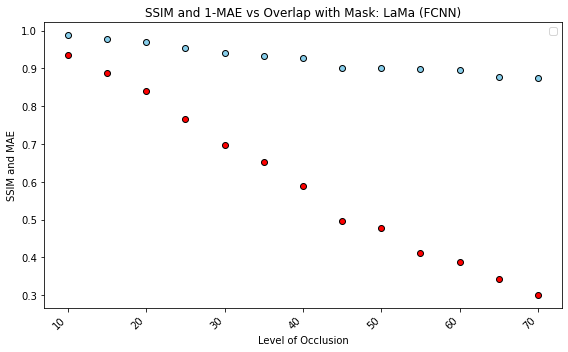

In [70]:
plt.figure(figsize=(8, 5))
plt.scatter(keys, mae_split_scores_lama, color='skyblue', edgecolor='black')
plt.scatter(keys, split_by_level_lama, color='red', edgecolor='black')
plt.title("SSIM and 1-MAE vs Overlap with Mask: LaMa (FCNN)")
plt.xlabel("Level of Occlusion")
plt.ylabel("SSIM and MAE")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig("mnist_obfuscated/lama_inpainted.png", dpi=300)
plt.show()